This notebook uses different layers of Llama3 as inputs to the MTEB (multitask embedding benchmark), which is an evaluation framework with a ton of datasets. The goal is to see if the layer-wise MTEB performance is correlated with entropy.

Authors: Oscar Skean

In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import torch.nn.functional as F
import numpy as np
from utils import get_model_path, get_dataloader, normalize, EleutherAI_sizes
import matplotlib.pyplot as plt
import tqdm
import repitl.matrix_itl as itl
from datasets import load_dataset, load_from_disk
from transformers.utils import logging
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
model_types = ["unidirectional-llama", "llm2vec-supervised"]
num_layers = 33
task_names = ["ArXivHierarchicalClusteringP2P", "Banking77Classification",  "EmotionClassification", "TwitterSemEval2015"]


In [5]:
import mteb
from models.mteb_model_wrapper import convert_model_name_to_loader

for model_type in model_types:
    for layer in reversed(range(num_layers)):
        model_loader = convert_model_name_to_loader(model_type)
        model = model_loader.loader(layer_cutoff=layer)
        
        # needed to properly save to folder
        model.mteb_model_meta = mteb.ModelMeta(
                        name=model_type,
                        revision=f"layer-{layer}",
                        release_date=None,
                        languages=None,
                    )

        tasks = mteb.get_tasks(tasks=task_names)

        evaluation = mteb.MTEB(tasks=tasks)
        results = evaluation.run(model)
        del model

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- TwitterSemEval2015, s2s

Clustering

- ArXivHierarchicalClusteringP2P, p2p

Classification

- Banking77Classification, s2s

- EmotionClassification, s2s

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# import mteb
# from models.mteb_model_wrapper import baseline_llama3, llm2vec_llama3_8b_supervised
# from utils import get_dataloader


# model_name = "baseline-llama"

# model = baseline_llama3.loader(layer_cutoff=2)
# dataloader = get_dataloader(model.model.tokenizer, "wikitext", split="train")

# with torch.no_grad():
#     for batch in tqdm.tqdm(dataloader):
#         batch = {k: v.to(model.model.model.device) for k, v in batch.items()}
#         outputs_2 = model.model.model(**batch)
        
#         break


# Calculate layer entropies

In [ ]:
import mteb
from models.mteb_model_wrapper import baseline_llama3, llm2vec_llama3_8b_supervised
from utils import get_model_path, get_dataloader, normalize, EleutherAI_sizes
from models.llm2vec import batch_to_device
import torch
import numpy as np
import repitl.matrix_itl as itl

def no_pooling_forward(model, sentence_feature):
    if "embed_mask" in sentence_feature:
        sentence_feature.pop("embed_mask")
    outputs = model.model(**sentence_feature)

    return outputs.hidden_states

def calculate_sentence_entropy(sentence_embeddings):
    N, D = sentence_embeddings.shape


    sentence_embeddings = normalize(sentence_embeddings)
    if N > D:
        cov = sentence_embeddings.T @ sentence_embeddings
    else:
        cov = (sentence_embeddings @ sentence_embeddings.T)
    cov /= torch.trace(cov)
    entropy = itl.matrixAlphaEntropy(cov, alpha=1)
    logN_normalized_entropy = entropy / np.log(N)

    return logN_normalized_entropy.item()

def calculate_batch_entropy(features, embeddings):
    seq_lengths = features["attention_mask"].sum(dim=-1)

    total_entropy = 0
    for i, length in enumerate(seq_lengths):
        sentence_entropy = calculate_sentence_entropy(embeddings[i, -length:, :].double())
        total_entropy += sentence_entropy
    
    return total_entropy

def encode_batch_and_get_layerwise_entropy(model, sentences_batch, layer_cutoff=-1, device=None):
    model.to(device)
    features = model.tokenize(
        [model.prepare_for_tokenization(sentence) for sentence in sentences_batch]
    )
    features = batch_to_device(features, device)
    with torch.no_grad():
        embeddings = no_pooling_forward(model, features)

        layerwise_entropies = []
        for layer in range(len(embeddings)):
            layerwise_entropies.append(calculate_batch_entropy(features, embeddings[layer].detach()))
    return layerwise_entropies

def encode_dataset_and_get_entropy(model, sentences, batch_size=8, device=None):
    if isinstance(sentences[0], str) and isinstance(sentences[-1], int):
        sentences = [sentences]
    # required for MEDI version of MTEB
    if isinstance(sentences[0], str):
        sentences = [[""] + [sentence] for sentence in sentences]

    concatenated_input_texts = []
    for sentence in sentences:
        assert isinstance(sentence[0], str)
        assert isinstance(sentence[1], str)
        concatenated_input_texts.append(
            model._convert_to_str(sentence[0], sentence[1])
        )
    sentences = concatenated_input_texts

    model.eval()
    length_sorted_idx = np.argsort([-model._text_length(sen) for sen in sentences])
    sentences_sorted = [sentences[idx] for idx in length_sorted_idx]

    batched_layerwise_entropies = []
    for i in tqdm.tqdm(range(0, len(sentences_sorted), batch_size)):
        sentences_batch = sentences_sorted[i : i + batch_size]

        layerwise_entropies = encode_batch_and_get_layerwise_entropy(model, sentences_batch, device=device)
        layerwise_entropies = [x / len(sentences_batch) for x in layerwise_entropies]
        batched_layerwise_entropies.append(layerwise_entropies)

    batched_layerwise_entropies = np.array(batched_layerwise_entropies)
    batched_layerwise_entropies = np.mean(batched_layerwise_entropies, axis=0)
    return batched_layerwise_entropies

In [ ]:
import mteb
import glob
import json


import mteb
from models.mteb_model_wrapper import convert_model_name_to_loader


tasks = mteb.get_tasks(tasks=task_names)
REDO_RESULTS = False
NUM_SAMPLES=64

for model_type in model_types:
    model_loader = convert_model_name_to_loader(model_type)
    model = model_loader.loader()

    model.model.eval()

    for task in tasks:
        # check if we've already calculated the entropy for this task
        if not REDO_RESULTS:
            with open(f"results/{model_type}/layer-0/{task.metadata.name}.json", "r") as f:
                results = json.load(f)
                if "avg_layerwise_entropy" in results:
                    print(f"Skipping {task.metadata.name} for {model_type} as it has already been calculated")
                    continue

        # load data from HF
        task.load_data(eval_splits=task.metadata.eval_splits)

        # load inputs
        task_dataset = task.dataset["test"]
        if "sentences" in task_dataset.features:
            sentences = task_dataset["sentences"]
        elif "text" in task_dataset.features:
            sentences = task_dataset["text"]
        else:
            print(task.dataset)
            print(task_dataset)
            raise ValueError("Dataset does not contain sentences or text, unsure where data is living")
        
        samples = sentences[0:NUM_SAMPLES]
        avg_layerwise_entropy = encode_dataset_and_get_entropy(model.model, samples)

        files = glob.glob(f"results/{model_type}/layer-*/{task.metadata.name}.json")
        for file in files:
            layer_num = int(file.split("/")[2].split("-")[1])

            # save entropy to json results file
            with open(file, "r") as f:
                results = json.load(f)
                results["avg_layerwise_entropy"] = avg_layerwise_entropy[layer_num]
                results["num_samples"] = len(samples)
                
            with open(file, "w") as f:
                json.dump(results, f)

    del model

# Load Results

In [7]:
import json
import glob
import pandas as pd

results_per_layer = {
    model_type: {
        task_name : {} for task_name in task_names
    } for model_type in model_types
}
entropies_per_layer = {
    model_type: {
        task_name : {} for task_name in task_names
    } for model_type in model_types
}

for model_type in model_types:
    for task_name in task_names:
        files = glob.glob(f"results/{model_type}/layer-*/{task_name}.json")
        print(files)
        for file in files:
            layer_num = int(file.split("/")[2].split("-")[1])

            with open(file, "r") as f:
                file_json = json.load(f)
            score = float(file_json["scores"]["test"][0]["main_score"])
            results_per_layer[model_type][task_name][layer_num] = score
            entropies_per_layer[model_type][task_name][layer_num] = float(file_json["avg_layerwise_entropy"])

        results_per_layer[model_type][task_name] = pd.Series(results_per_layer[model_type][task_name])
        results_per_layer[model_type][task_name] = results_per_layer[model_type][task_name].sort_index()

        entropies_per_layer[model_type][task_name] = pd.Series(entropies_per_layer[model_type][task_name])
        entropies_per_layer[model_type][task_name] = entropies_per_layer[model_type][task_name].sort_index()

['results/baseline-llama/layer-6/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-11/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-18/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-0/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-24/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-20/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-26/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-31/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-10/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-19/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-29/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-22/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-30/ArXivHierarchicalClusteringP2P.json', 'results/baseline-llama/layer-15/ArXivHierarchicalClusteringP2P.json', 'result

In [ ]:
print(results_per_layer)

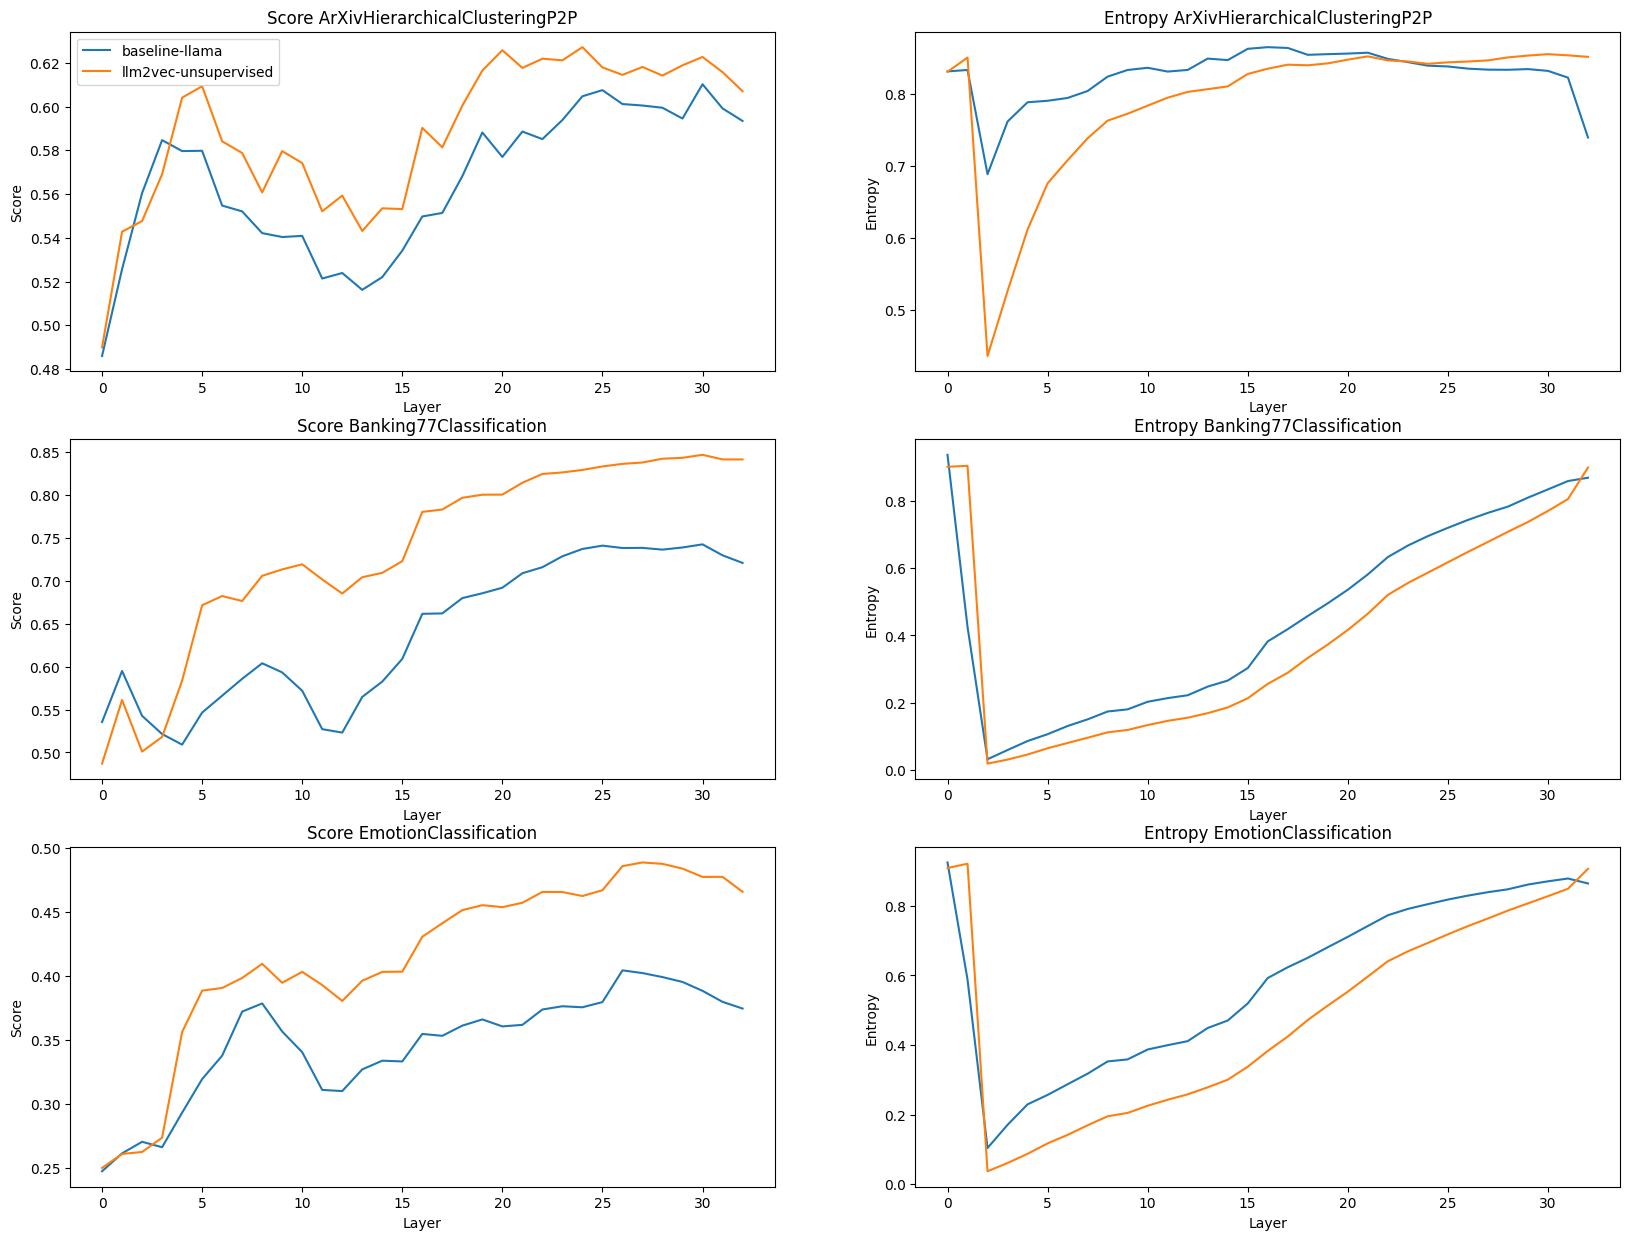

In [8]:
fig, axes = plt.subplots(len(task_names), 2, figsize=(20, 15))
for i, task_name in enumerate(task_names):
    for j, model_name in enumerate(model_types):
        axes[i, 0].plot(results_per_layer[model_name][task_name], label=model_name)
        axes[i, 0].set_title(f"Score {task_name}")
        axes[i, 0].set_xlabel("Layer")
        axes[i, 0].set_ylabel("Score")

        axes[i, 1].plot(entropies_per_layer[model_name][task_name], label=model_name)
        axes[i, 1].set_title(f"Entropy {task_name}")
        axes[i, 1].set_xlabel("Layer")
        axes[i, 1].set_ylabel("Entropy")

axes[0,0].legend()

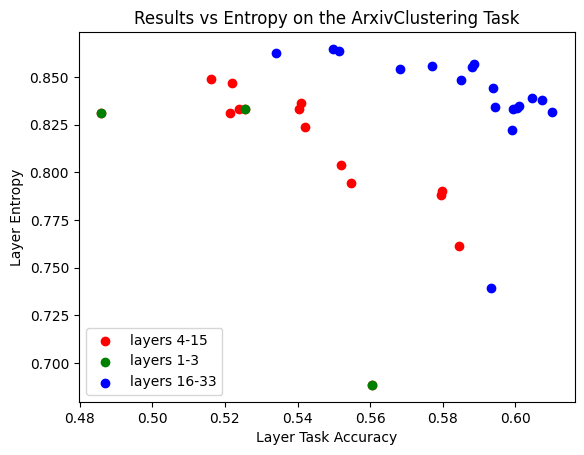

In [17]:
#print(entropies_per_layer)

plt.title("Results vs Entropy on the ArxivClustering Task")
plt.xlabel("Layer Task Accuracy")
plt.ylabel("Layer Entropy")

plt.scatter(results_per_layer[0:15], entropies_per_layer[0:15], color="red", label="layers 4-15")
plt.scatter(results_per_layer[0:3], entropies_per_layer[0:3], color="green", label="layers 1-3")
plt.scatter(results_per_layer[15:], entropies_per_layer[15:], color="blue", label="layers 16-33")
plt.legend()

try more datasets
try more models (llama instruct)
try dataset that the model was trained on

on ood data, should be less compression
	can you interpolate between trained/untrained data and show how compression is controllable
	